In [2]:
import multiprocessing
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3 import DQN

import time
import numpy as np
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from PIL import Image

2024-01-28 14:16:32.900697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 14:16:32.900739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 14:16:32.901946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 14:16:32.909174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 14:16:33.826389: W tensorflow/compiler/tf2

In [3]:
num_cpu = multiprocessing.cpu_count()
print("Number of CPUs:", num_cpu)

n_env = 1
print("Creating environment with {} processes".format(n_env))

# Create the environment with 4 stacked frames
env = make_atari_env("ALE/MsPacman-v5")
env = VecFrameStack(env, n_stack=4)
#env = VecVideoRecorder(env, "./video/", record_video_trigger=lambda x: x == 0, video_length=400, name_prefix="dqn-agent")

Number of CPUs: 8
Creating environment with 1 processes


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [4]:
# load model
model_path = "./stable_DQN/model/stable_model_1milion.zip"
model = DQN.load(model_path)

/home/mister/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/home/mister/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


In [5]:
import random
from tqdm import tqdm
from DQN.utils import ExperienceReplay, LogData
checkpoint_dir = "./stable_DQN/checkpoints/"
n_stack = 4
eps = 0.05

def evaluate(model, total_episodes):
    obs = env.reset()
    n_actions = env.action_space.n

    episode_reward = [0] * n_env
    episodes = 0
    steps = 0
    evaluation_log = LogData(checkpoint_dir, None, n_env, n_stack, training=False)

    pbar = tqdm(total = total_episodes, desc="Evaluation", unit="episode")

    while episodes < total_episodes:

        if eps >= random.random():
            actions = [random.randint(0, n_actions - 1) for _ in range(n_env)]
        else:
            actions = model.predict(obs)[0]

        next_obs, rewards, dones, infos = env.step(actions)
        steps += 1 * n_env
        episode_reward = [episode_reward[i] + rewards[i] for i in range(n_env)]

        for i in range(n_env):
            if dones[i]:
                if infos[i]['lives'] == 0 or infos[i]['TimeLimit.truncated']:
                    episodes += 1
                    pbar.update(1)
                    evaluation_log.add_episode_data(steps, infos[i]['episode'], [], 0, [eps], episode_reward[i])
                    episode_reward[i] = 0
                    if episodes >= total_episodes:
                        break
        obs = next_obs
    pbar.close()
    evaluation_log.print_statistics()
    print("Evaluation finished")
    return evaluation_log

In [6]:
log = evaluate(model, 1000)

Evaluation: 100%|██████████| 1000/1000 [15:57<00:00,  1.04episode/s]

=========================== Evaluation Summary ===========================
Episode Length Mean: 950
Episode Reward Mean: 113
Episode Score Mean: 2173
Exploration Rate: 0.05
Episodes: 1000
Time Elapsed: 965.09 seconds
Total Timesteps: 232032
CPU Memory Usage: 0.99 GB
CPU Usage: 38.2%
Evaluation finished


In [ ]:
log.save_data()

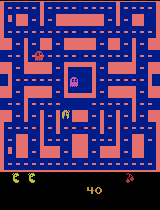

KeyboardInterrupt: 

In [16]:
# Create a virtual display
display = Display(visible=0, size=(1200, 1200))
display.start()

data = {i: [[]] for i in range(n_env)}
tmp_data = {i: 1 for i in range(n_env)}

obs = env.reset()

while True:
    actions, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(actions)
    
    for i in range(n_env):
        if tmp_data[i]-1 >= len(data[i]):
            data[i].append([])
        if rewards[i] is not None:  # Check if the reward is not None
            data[i][tmp_data[i]-1].append(rewards[i])
        if dones[i]:
            tmp_data[i] += 1

    # Render the environment and display the frame
    screen = env.render()
    # Convert the RGB array to an image
    screen = Image.fromarray(screen)

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(screen)
    
    time.sleep(1/8)  # Delay for 1/30 seconds to achieve ~30 fps

    if all([tmp_data[i] > 3 for i in range(n_env)]):
        break

ipythondisplay.clear_output(wait=True)
env.close()

In [17]:
import copy
from pprint import pprint

copy_data = copy.deepcopy(data)

for i in range(n_env):
    for j in range(len(copy_data[i])):
        copy_data[i][j] = [np.sum(copy_data[i][j]), len(copy_data[i][j])]

pprint(copy_data)


{0: [[3.0, 15]]}


In [18]:
for i in range(n_env):
    print("Total episodes for CPU", i, ":", len(copy_data[i][0]))
    print("Total reward for CPU", i, ":", sum([copy_data[i][j][0] for j in range(len(copy_data[i]))]), "with average reward", format(sum([copy_data[i][j][0] for j in range(len(copy_data[i]))])/len(copy_data[i]), '.2f'))
    print("Total steps for CPU", i, ":", sum([copy_data[i][j][1] for j in range(len(copy_data[i]))]), "with average steps", format(sum([copy_data[i][j][1] for j in range(len(copy_data[i]))])/len(copy_data[i]), '.2f'))
    print("Weighted average reward for CPU", i, ":", format(sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(len(copy_data[i]))])/sum([copy_data[i][j][1] for j in range(len(copy_data[i]))]), '.2f'))
    print()

print("Total episodes:", sum([len(copy_data[i]) for i in range(n_env)]))

Total episodes for CPU 0 : 2
Total reward for CPU 0 : 3.0 with average reward 3.00
Total steps for CPU 0 : 15 with average steps 15.00
Weighted average reward for CPU 0 : 3.00

Total episodes: 1


In [2]:
data_file = "./raw_data.txt"

data_list = []
current_dict = {}

with open(data_file, "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith("|"):
            key, value = line.split("|")[1:-1]
            key = key.strip()
            if not key.endswith("/"):
                current_dict[key] = value.strip()
        elif line.startswith("-"):
            if current_dict:
                data_list.append(current_dict)
                current_dict = {}


In [3]:
from pprint import pprint
pprint(data_list[0])

{'ep_len_mean': '595',
 'ep_rew_mean': '530',
 'episodes': '4',
 'exploration_rate': '0.998',
 'fps': '172',
 'time_elapsed': '1',
 'total_timesteps': '183'}


In [4]:
import pandas as pd

df = pd.DataFrame(data_list)

# Convert columns to numeric
numeric_columns = ['ep_len_mean', 'ep_rew_mean', 'episodes', 'exploration_rate', 'fps', 'learning_rate', 'loss', 'n_updates', 'time_elapsed', 'total_timesteps']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

In [6]:
new_column_names = {'ep_len_mean': 'len',
                    'ep_rew_mean': 'reward',
                    'episodes': 'games',
                    'exploration_rate': 'eps',
                    'fps': 'fps',
                    'learning_rate': 'learning_rate',
                    'loss': 'loss_mean',
                    'n_updates': 'n_updates',
                    'time_elapsed': 'time',
                    'total_timesteps': 'timesteps'}

df = df.rename(columns=new_column_names)
df['games'] = df['games'] / 3

# Create column 'time_per_episode' and round to 2 decimal places
df['time_per_episode'] = (df['time'].diff() / 4).round(2)

df.to_json("./checkpoints/data_stable_1milion_2.json")

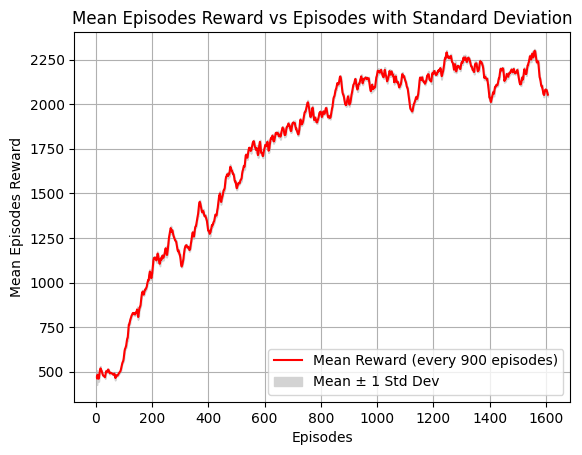

In [12]:
from matplotlib import pyplot as plt

# Calculate rolling mean and std for every 900 games
rolling_mean = df['reward'].rolling(window=9).mean()
rolling_std = df['reward'].rolling(window=9).std()

plt.plot(df['games'], rolling_mean, color='red', label='Mean Reward (every 900 episodes)')

# Plot standard deviation as a shaded region
plt.fill_between(df['games'], rolling_mean - rolling_std, rolling_mean + rolling_std, color='lightgray', label='Mean ± 1 Std Dev')
plt.xlabel('Episodes')
plt.ylabel('Mean Episodes Reward')
plt.title('Mean Episodes Reward')
plt.grid(True)
plt.legend()
plt.show()

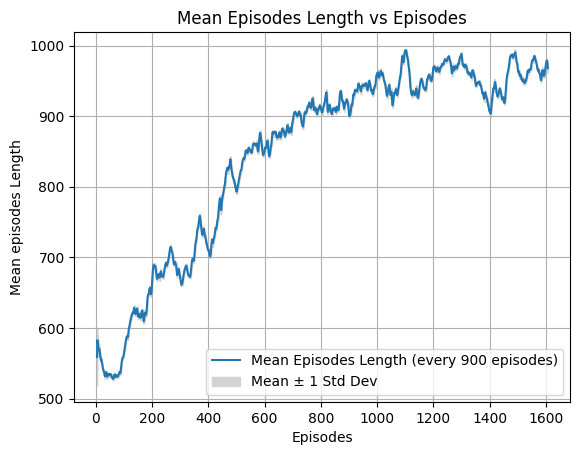

In [13]:
game_len_mean = df['len'].rolling(window=9).mean()
game_len_std = df['len'].rolling(window=9).std()

plt.plot(df['games'], game_len_mean, label='Mean Episodes Length (every 900 episodes)')
plt.fill_between(df['games'], game_len_mean - game_len_std, game_len_mean + game_len_std, color='lightgray', label='Mean ± 1 Std Dev')

plt.xlabel('Episodes')
plt.ylabel('Mean episodes Length')
plt.title('Mean Episodes Length vs Episodes')
plt.grid(True)
plt.legend()
plt.show()

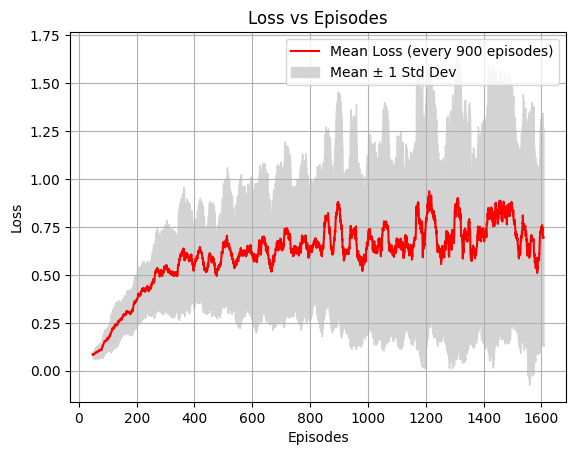

In [21]:
loss_mean = df['loss_mean'].rolling(window=50).mean()
loss_std = df['loss_mean'].rolling(window=50).std()

plt.plot(df['games'], loss_mean, color='red', label='Mean Loss (every 900 episodes)')
plt.fill_between(df['games'], loss_mean - loss_std, loss_mean + loss_std, color='lightgray', label='Mean ± 1 Std Dev')

plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Loss vs Episodes')
plt.legend()
plt.grid(True)
plt.show()

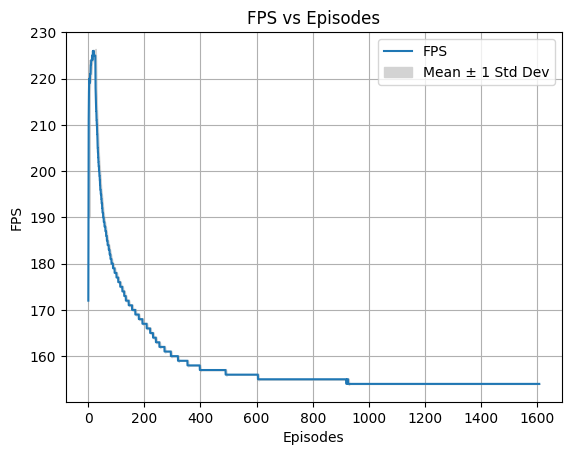

In [23]:
fps_mean = df['fps'].rolling(window=9).mean()
fps_std = df['fps'].rolling(window=9).std()

plt.plot(df['games'], df['fps'], label='FPS')
plt.fill_between(df['games'], fps_mean - fps_std, fps_mean + fps_std, color='lightgray', label='Mean ± 1 Std Dev')

plt.xlabel('Episodes')
plt.ylabel('FPS')
plt.title('FPS vs Episodes')
plt.legend()
plt.grid(True)
plt.show()

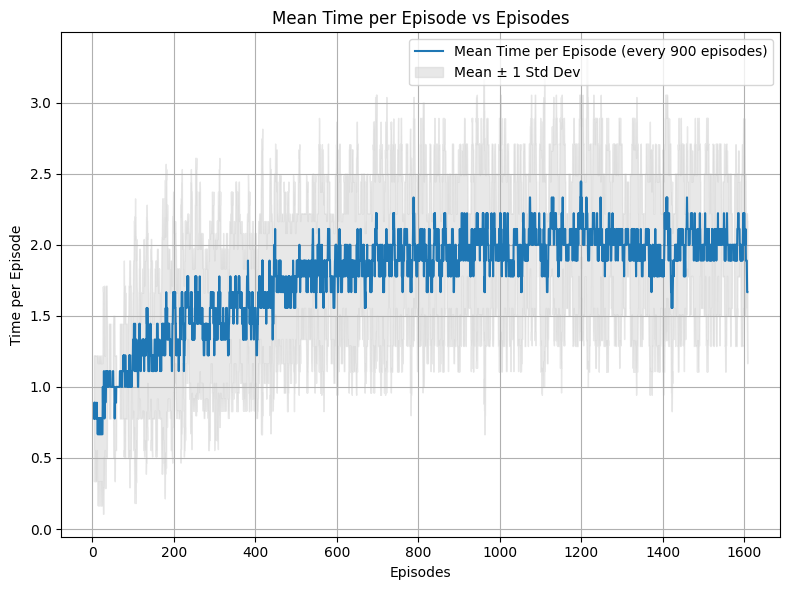

In [27]:
# Calculate time per episode by subtracting the previous episode's time
df['time_per_episode'] = df['time'].diff()

# Calculate rolling mean and standard deviation for time per episode
time_per_episode_mean = df['time_per_episode'].rolling(window=9).mean()
time_per_episode_std = df['time_per_episode'].rolling(window=9).std()

# Plot for 'games' vs 'time_per_episode'
plt.figure(figsize=(8, 6))

plt.plot(df['games'], time_per_episode_mean, label='Mean Time per Episode (every 900 episodes)')
plt.fill_between(df['games'], time_per_episode_mean - time_per_episode_std, time_per_episode_mean + time_per_episode_std, color='lightgray', label='Mean ± 1 Std Dev', alpha=0.5)

plt.xlabel('Episodes')
plt.ylabel('Time per Episode')
plt.title('Mean Time per Episode vs Episodes')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()